In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score
from keras.layers import LSTM, Dense,Input,Layer
from keras import backend as K,Model
from numpy.random import seed
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDOneClassSVM
seed(0)
import os
os.environ['PYTHONHASHSEED']=str(0)
from sklearn.metrics import roc_curve,roc_auc_score
import tensorflow as tf
tf.random.set_seed(0)
import random
import random as python_random
python_random.seed(0)
random.seed(0)
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay

In [2]:
data = pd.read_csv('creditcard.csv', na_filter=True)

data.drop(['Time'], axis=1, inplace=True)
selected_vars =['V4','V14','V10','V16','V9','V12','V11','V17','V7','V21','V18','V8','V1','V3','V6','V2','V27','V5','V26','Class']


In [3]:
tr_data = data[selected_vars]
tr_data.shape

(284807, 20)

In [4]:
X = tr_data.drop(['Class'], axis = 'columns')
Label_Data = tr_data['Class']

In [5]:
y=tr_data['Class']

Epoch 1/10
440/440 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - Precision: 0.0138 - Recall: 0.2050 - loss: 0.2165 - val_Precision: 0.8788 - val_Recall: 0.5743 - val_loss: 0.0043
Epoch 2/10
440/440 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - Precision: 0.8776 - Recall: 0.5990 - loss: 0.0039 - val_Precision: 0.8750 - val_Recall: 0.7624 - val_loss: 0.0034
Epoch 3/10
440/440 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - Precision: 0.8751 - Recall: 0.7604 - loss: 0.0033 - val_Precision: 0.8681 - val_Recall: 0.7822 - val_loss: 0.0031
Epoch 4/10
440/440 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - Precision: 0.8785 - Recall: 0.7945 - loss: 0.0030 - val_Precision: 0.8710 - val_Recall: 0.8020 - val_loss: 0.0030
Epoch 5/10
440/440 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - Precision: 0.8892 - Recall: 0.8011 - loss: 0.0029 - val_Precision: 0.8710 - val_Recall: 0.8020 - val_loss: 0.0030
Epoch 6/10
440/440 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - Precision: 0.8938 - Recall: 0.8011 - loss: 0.0027 - val_Precision: 0.8710 - val_Recall: 0.8020 - val_loss:

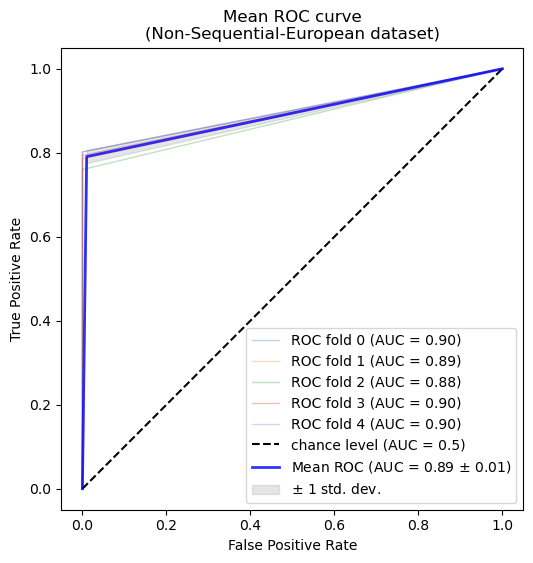

In [76]:
from sklearn.metrics import accuracy_score
from statistics import mean
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

kf = KFold(n_splits=5, shuffle = True,random_state=0)
f1=[]
acc=[]
recall=[]
precision=[]
AUC=[]
prs = []
aucs = []
k=0
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots(figsize=(6, 6))
for train_index, test_index in kf.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    SZ=StandardScaler()
    X_train = pd.DataFrame(SZ.fit_transform(X_train), index=X_train.index)
    X_test = pd.DataFrame(SZ.transform(X_test), index=X_test.index)

    df1_normal=X_train[y_train==0]
    clf = SGDOneClassSVM(nu=0.025,random_state=0)
    res = clf.fit_predict(df1_normal)
    res[res==1] = 0
    res[res==-1] = 1
    ros = RandomUnderSampler(sampling_strategy=0.95)
    ros.fit_resample(df1_normal,res)
    index=ros.sample_indices_
    X_train.drop(X_train.index[index], inplace=True)
    y_train.drop(y_train.index[index], inplace=True)
    train_LSTM_X=X_train.to_numpy()
    test_LSTM_X=X_test.to_numpy()
    train_LSTM_y=y_train.to_numpy()
    test_LSTM_y=y_test.to_numpy()
    w=3
    X_train=np.zeros([train_LSTM_X.shape[0]-w+1,w, train_LSTM_X.shape[1]])
    for i in range(train_LSTM_X.shape[0]-w+1):
        for j in range(w):
            X_train[i][j]=train_LSTM_X[i+j]
    X_test=np.zeros([test_LSTM_X.shape[0]-w+1,w, test_LSTM_X.shape[1]])
    for i in range(test_LSTM_X.shape[0]-w+1):
        for j in range(w):
            X_test[i][j]=test_LSTM_X[i+j]

    y_train=np.delete(train_LSTM_y,[*range(0, w-1, 1)], 0)
    y_test=np.delete(test_LSTM_y,[*range(0, w-1, 1)], 0)
    inputs=Input((w,19))
    x1=LSTM(50)(inputs)
    outputs=Dense(1,activation='sigmoid')(x1)
    model=Model(inputs,outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['Precision','Recall'])
    history1=model.fit(X_train, y_train,epochs=10,batch_size=500,validation_data=(X_test,y_test))
    yhat_probs = model.predict(X_test, verbose=0)
    yhat_probs =  yhat_probs[:, 0]> 0.5
    preds=yhat_probs.astype(int)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, preds, pos_label=1)
    AUC.append(metrics.auc(fpr, tpr))
    f1.append(f1_score(y_test, preds))
    acc.append(accuracy_score(y_test, preds))
    recall.append(recall_score(y_test,preds))
    precision.append(precision_score(y_test, preds))
    viz = RocCurveDisplay.from_predictions(
        y_test,
        preds,
        name=f"ROC fold {k}",
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    k+=1
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
print("Mean ACC: ",mean(acc)," Mean precision: ",mean(precision)," Mean Recall: ",mean(recall)," Mean F1: ",mean(f1)," Mean AUC: ",mean(AUC))
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
title=f"Mean ROC curve\n(Non-Sequential-European dataset)",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()